In [1]:
import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging

# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [3]:
from matplotlib import pylab as plt

In [4]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np

In [6]:
T0_isot = "2022-10-09T13:17:00"

T0_ijd = Time(T0_isot).mjd - 51544


In [7]:
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"

In [8]:
src_coord.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    (52.95942238, 4.32250154)>

In [9]:
# scw_dict = pd.DataFrame(requests.get("https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/nrt/2022-10-08T00:39:04/2022-10-23T08:02:00?"
scw_dict = pd.DataFrame(requests.get("https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/nrt/2022-10-11T10:39:04/2022-10-13T10:02:00?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=10&return_columns=SWID,SW_TYPE,TELAPSE").json())

scw_list = scw_dict['SWID'][scw_dict['SW_TYPE'].str.strip() == "POINTING"]

print("\n".join(scw_list))

255900010010
255900020010
255900030010
255900040010
255900050010
255900060010
255900070010
255900080010
255900090010
255900100010
255900110010
255900120010
255900130010
255900140010
255900150010
255900160010
255900170010
255900180010
255900190010
255900200010
255900210010
255900220010
255900230010
255900240010
255900250010
255900260010


In [10]:
np.sum(scw_dict.TELAPSE[scw_dict['SW_TYPE'].str.strip() == "POINTING"])

81476.05373292463

In [11]:
disp = oda_api.api.DispatcherAPI()
disp.use_local_cache = True

jemx_image = disp.get_product(
    instrument="jemx",
    product="jemx_image",
    E1_keV=3,
    E2_keV=30,
    integral_data_rights="all-private",
    scw_list=[s + ".000" for s in scw_list],
    token=oda_api.token.discover_token()
#     src_coord
)

found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1665754870,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
INFO:oda_api.token:found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1665754870,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
token expires in 46.4 h
INFO:oda_api.token:token expires in 46.4 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbos

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59862.602477 from DATE-OBS.
Set MJD-END to 59864.287905 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59862.602477 from DATE-OBS.
Set MJD-END to 59864.287905 from DATE-END'.
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


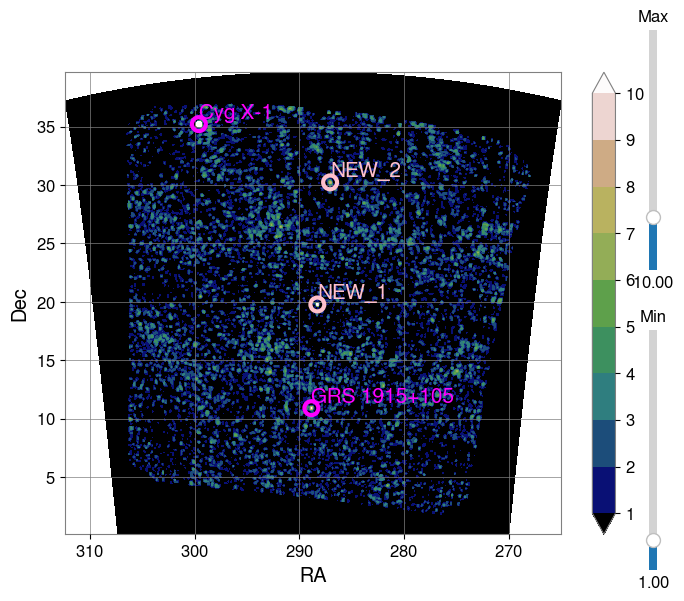

In [ ]:
oda_api.plot_tools.OdaImage(jemx_image).show()

In [ ]:
jemx_image.mosaic_image_0_mosaic.data_unit[4].header

{'BASETYPE': 'DAL_ARRAY',
 'BITPIX': -32,
 'BSCALE': 1,
 'BUNIT': 'no units',
 'BZERO': 0,
 'CD1_1': -0.0822862539155913,
 'CD1_2': 0.0,
 'CD2_1': 0.0,
 'CD2_2': 0.0822862539155913,
 'CHANMAX': 80,
 'CHANMIN': 28,
 'CHANTYPE': 'PI',
 'CHECKSUM': 'XAApX27nX8AnX85n',
 'COMMENT': 'STAMP :',
 'CONFIGUR': 'osa_2021-08-27T14:27:00',
 'CREATOR': 'ii_skyimage 5.4.4',
 'CRPIX1': 251.0,
 'CRPIX2': 251.0,
 'CRVAL1': 288.654907226562,
 'CRVAL2': 19.8967514038086,
 'CTYPE1': 'RA---TAN',
 'CTYPE2': 'DEC--TAN',
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'DATASUM': '2861657160',
 'DATE': '2022-10-12T09:00:19',
 'DATE-END': '2022-10-12T06:54:35',
 'DATE-OBS': '2022-10-10T14:27:34',
 'DEADC': 0.709733134907423,
 'DETNAM': 'ISGRI',
 'EQUINOX': 2000.0,
 'EXTNAME': 'ISGR-MOSA-IMA',
 'EXTREL': '7.4',
 'EXTVER': 3,
 'E_MAX': 80.0,
 'E_MEAN': 54.0,
 'E_MIN': 28.0,
 'GCOUNT': 1,
 'GRPID1': 1,
 'HDUCLAS1': 'IMAGE',
 'HDUCLASS': 'OGIP',
 'HDUDOC': 'ISDC-IBIS ICD',
 'HDUVERS': '1.1.0',
 'IMATYPE': 'SIGNIFICANCE',
 'INS

In [ ]:
cat = jemx_image.dispatcher_catalog_1

toremove = []
for i, r in enumerate(cat.table.iterrows()):
    print(r)
    if r[1].startswith('NEW_') or r[1].startswith('GRB') or r[1].startswith('SGR'):
        toremove.append(i)        

cat.table.add_row(
{
    'src_names': source_name,
    'ra': src_coord.ra.deg,
    'dec': src_coord.dec.deg,
    'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})

sgr = SkyCoord.from_name('SGR 1935+2154')
cat.table.add_row(
{
    'src_names': 'SGR 1935+2154',
    'ra': sgr.ra.deg,
    'dec': sgr.dec.deg,
    'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})


cat.table.remove_rows(toremove)

cat.table

NameError: name 'isgri_image' is not defined

In [ ]:
from astropy.table import Table

m_source = [not s.startswith('NEW') for s in cat.table['src_names']]
cat.table = Table(cat.table[m_source])

cat.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[9, 10, 0], ["Cyg X-1", "GRS 1915+105", "GRB221009A"], [91.33380889892578, 10.135880470275879, 0.0], [299.5925598144531, 288.84332275390625, 288.26429166666657], [35.20620346069336, 10.917649269104004, 19.773083333333332], [-32768, -32768, 0], [2, 2, 1], [0, 0, 1], [0.0002800000074785203, 0.0002800000074785203, 0.05]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U12"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

In [ ]:
from ddpaper.draftdata import DraftData

with DraftData() as dd:
    dd['obs'] = dict(
        tstart_isot="",
        tstop_isot=""
    )


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  self.data = yaml.load(


In [ ]:
source_products = {}

for product in [
        "isgri_lc",
        "isgri_spectrum",
        "isgri_image",
        "isgrihe_image",
        "jemx1_lc",
        "jemx1_spectrum",
        "jemx1_image",
        "jemx2_lc",
        "jemx2_spectrum",
        "jemx2_image",
    ]:
    disp.wait = False
    
    if 'jemx' in product:
        e1, e2 = 3, 30
    else:
        e1, e2 = 28, 80
    
    jnum = 1
    product_pass = product

    if 'jemx1' in product:
        jnum=1
        product_pass = product.replace("jemx1_", "jemx_")
    elif 'jemx2' in product:
        jnum=2
        product_pass = product.replace("jemx2_", "jemx_")
    elif 'isgrihe' in product:
        e1, e2 = 80, 200
        product_pass = product.replace("isgrihe_", "isgri_")
    
    source_products[product] = disp.get_product(
        instrument=product_pass.split("_")[0],
        product=product_pass,
        osa_version="OSA11.2",
        scw_list=[s+".000" for s in scw_list],
        token = oda_api.token.discover_token(),
        E1_keV=e1,
        E2_keV=e2,
        jemx_num=jnum,
        selected_catalog=cat.get_api_dictionary(),
        integral_data_rights="all-private",
    )

found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1665754870,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
INFO:oda_api.token:found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1665754870,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
token expires in 51.6 h
INFO:oda_api.token:token expires in 51.6 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbos

In [ ]:
source_products

{'isgri_lc': <oda_api.api.DataCollection at 0x7f81b8f841f0>,
 'isgri_spectrum': <oda_api.api.DataCollection at 0x7f81b70c0b50>,
 'isgri_image': <oda_api.api.DataCollection at 0x7f81b6fb1280>,
 'isgrihe_image': <oda_api.api.DataCollection at 0x7f81b6bda910>,
 'jemx1_lc': <oda_api.api.DataCollection at 0x7f81b6f8e0d0>,
 'jemx1_spectrum': <oda_api.api.DataCollection at 0x7f8194494940>,
 'jemx1_image': <oda_api.api.DataCollection at 0x7f81945ce250>,
 'jemx2_lc': <oda_api.api.DataCollection at 0x7f81b8f02c40>,
 'jemx2_spectrum': <oda_api.api.DataCollection at 0x7f81942bc040>,
 'jemx2_image': <oda_api.api.DataCollection at 0x7f819464d370>}

In [ ]:
d = source_products['isgrihe_image']
d.dispatcher_catalog_1.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 3], ["Cyg X-1", "NEW_1"], [24.418664932250977, 7.100205421447754], [299.60009765625, 276.1963806152344], [35.19633865356445, 4.745615005493164], [-32768, -32767], [2, 0], [0, 0], [0.0, null]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U7"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.err

no GRB here!


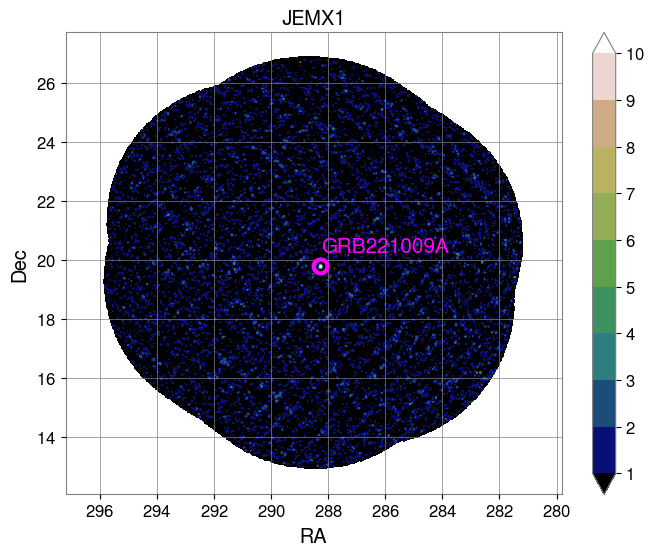

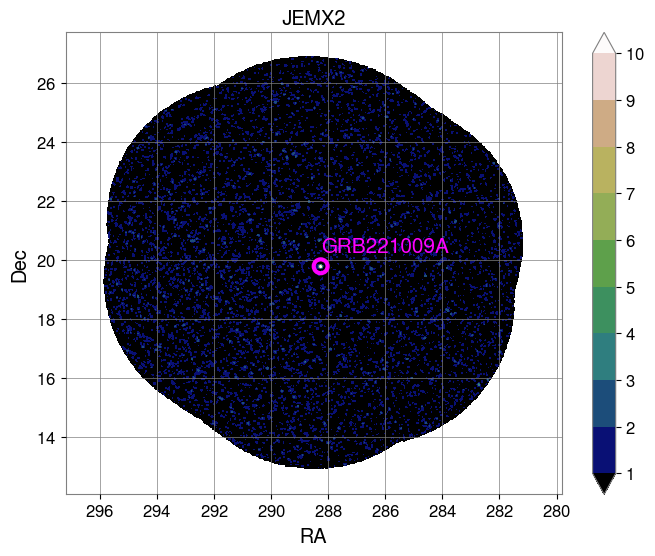

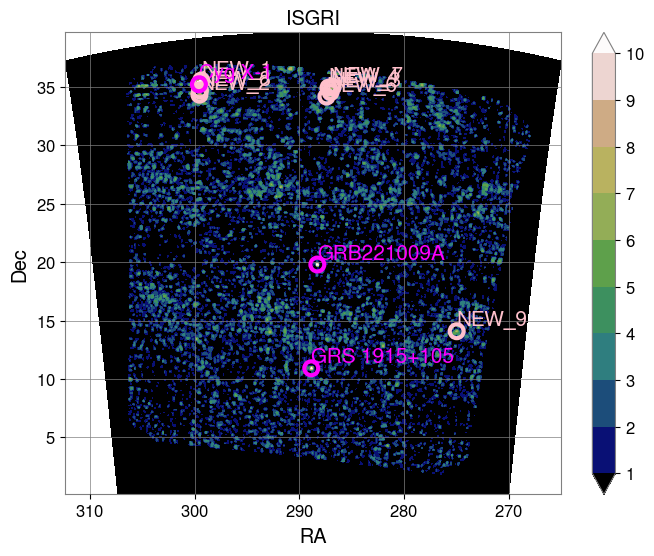

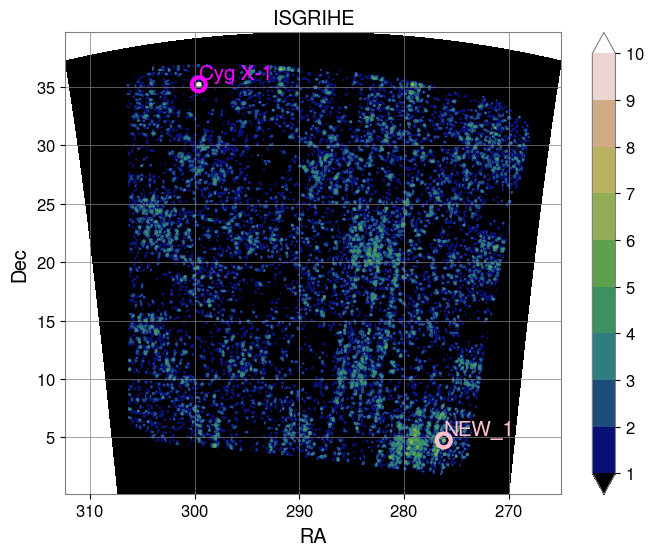

In [ ]:
for instrument in 'jemx1', 'jemx2', 'isgri', 'isgrihe':
    p = source_products[instrument + '_image']
    oda_api.plot_tools.OdaImage(p).show(sliders=False) #, header="JEM-X")
    oda_api.plot_tools.OdaImage(p).write_fits(instrument + "_")
    plt.title(instrument.upper())
    plt.savefig(f"figs/{instrument}.png")

    with DraftData() as dd:
        try:
            dd[instrument] = {'snr': float(p.dispatcher_catalog_1.table[p.dispatcher_catalog_1.table['src_names'] == "GRB221009A"]['significance'][0])}
        except IndexError:
            print("no GRB here!")
        


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:450: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


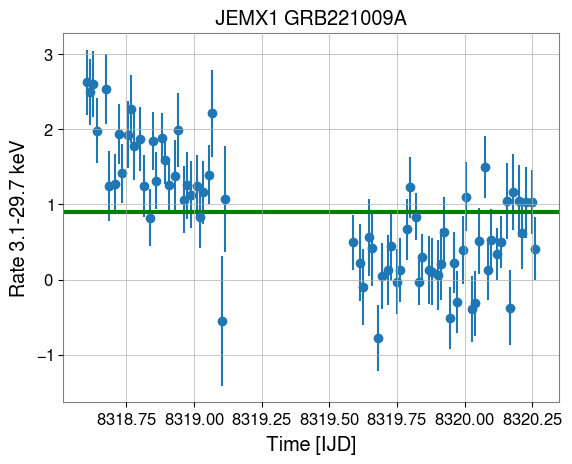

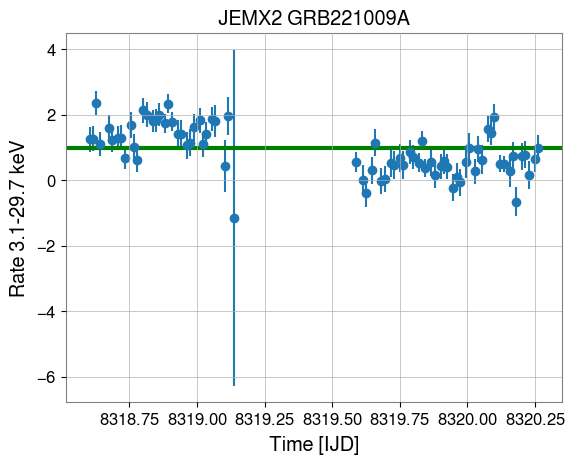

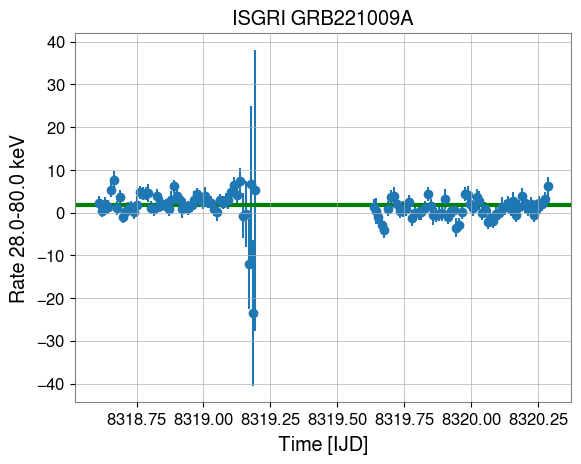

In [ ]:
for instrument in 'jemx1', 'jemx2', 'isgri':
    oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).show(in_source_name='GRB221009A')
    oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).write_fits('GRB221009A')
    plt.title(instrument.upper() + " " + source_name)
    plt.savefig(f"figs/lc_{instrument}.png")


In [ ]:
for instrument in 'jemx1', 'jemx2', 'isgri':
    p = source_products[instrument + '_spectrum']
    oda_api.plot_tools.OdaSpectrum(source_products[instrument + '_spectrum']).write_fits('GRB221009A')
    
    spec = getattr(p, [l['prod_name'] for l in p.as_list() if l['meta_data:']['src_name'] == 'GRB221009A'][0])
    
    with DraftData() as dd:
        dd[instrument]['exposure_s'] = spec.data_unit[1].header['EXPOSURE']
 


Saving spectrum ./JMX1_spectrum_GRB221009A.fits with rmf ./JMX1_rmf_GRB221009A.fits and arf ./JMX1_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX1_spectrum_GRB221009A.fits with rmf ./JMX1_rmf_GRB221009A.fits and arf ./JMX1_arf_GRB221009A.fits
Saving spectrum ./JMX2_spectrum_GRB221009A.fits with rmf ./JMX2_rmf_GRB221009A.fits and arf ./JMX2_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX2_spectrum_GRB221009A.fits with rmf ./JMX2_rmf_GRB221009A.fits and arf ./JMX2_arf_GRB221009A.fits
Saving spectrum ./IBIS_spectrum_GRB221009A.fits with rmf ./IBIS_rmf_GRB221009A.fits and arf ./IBIS_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./IBIS_spectrum_GRB221009A.fits with rmf ./IBIS_rmf_GRB221009A.fits and arf ./IBIS_arf_GRB221009A.fits


In [ ]:
with DraftData() as dd:
    dd['joint_fit'] = dict(
        e1_keV=3,
        e2_keV=80,
        flux_ecs = 4.4263e-10, # ergs/cm^2/s) range (3.0000 - 80.000 keV
        flux_ecs_err_68p = (4.215e-10 - 4.4263e-10, 4.670e-10 - 4.4263e-10),
        slope = 2.15041,
        slope_err_90p = (-0.0712388,0.0841283)
    )

In [ ]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/20000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc

,t,dt,c,ds
0,8317.321991,0.022610,5460.0,27750.838610
1,8317.321992,0.072609,5432.0,27750.888609
2,8317.321992,0.122610,5340.0,27750.938610
3,8317.321993,0.172610,5386.0,27750.988610
4,8317.321993,0.222609,5238.0,27751.038609
...,...,...,...,...
799995,8317.784951,39999.799670,5328.0,67750.615673
799996,8317.784952,39999.849670,5276.0,67750.665672
799997,8317.784953,39999.899680,5212.0,67750.715675
799998,8317.784953,39999.949670,5278.0,67750.765675


In [ ]:
bkg = np.mean(acslc.c[acslc.t<T0_ijd - 1000./24/3600])


def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


from scipy.optimize import curve_fit

F = lambda x,a,b,c,d: a+b*x+c*x**2+d*x**3
n = 1000
T = (rebin(acslc.t, n)/n - T0_ijd)*24
m = T < -1
m |= T > 3

curve = curve_fit(
    F,
    T[m],
    (rebin(acslc.c, n)/n - bkg)[m]
    )


curve

(array([-1.45827937e+01, -4.29916314e+00,  2.10266238e-01,
         2.92586516e-03]),
 array([[ 1.10826164e-01,  2.08051289e-02, -5.47696719e-03,
         -8.94704751e-04],
        [ 2.08051289e-02,  1.56255518e-02, -9.45498371e-04,
         -6.90606191e-04],
        [-5.47696719e-03, -9.45498371e-04,  3.42733153e-04,
          4.07157718e-05],
        [-8.94704751e-04, -6.90606191e-04,  4.07157718e-05,
          3.37193130e-05]]))

Text(0.5, 0, 'hours since 2022-10-09T13:17:00')

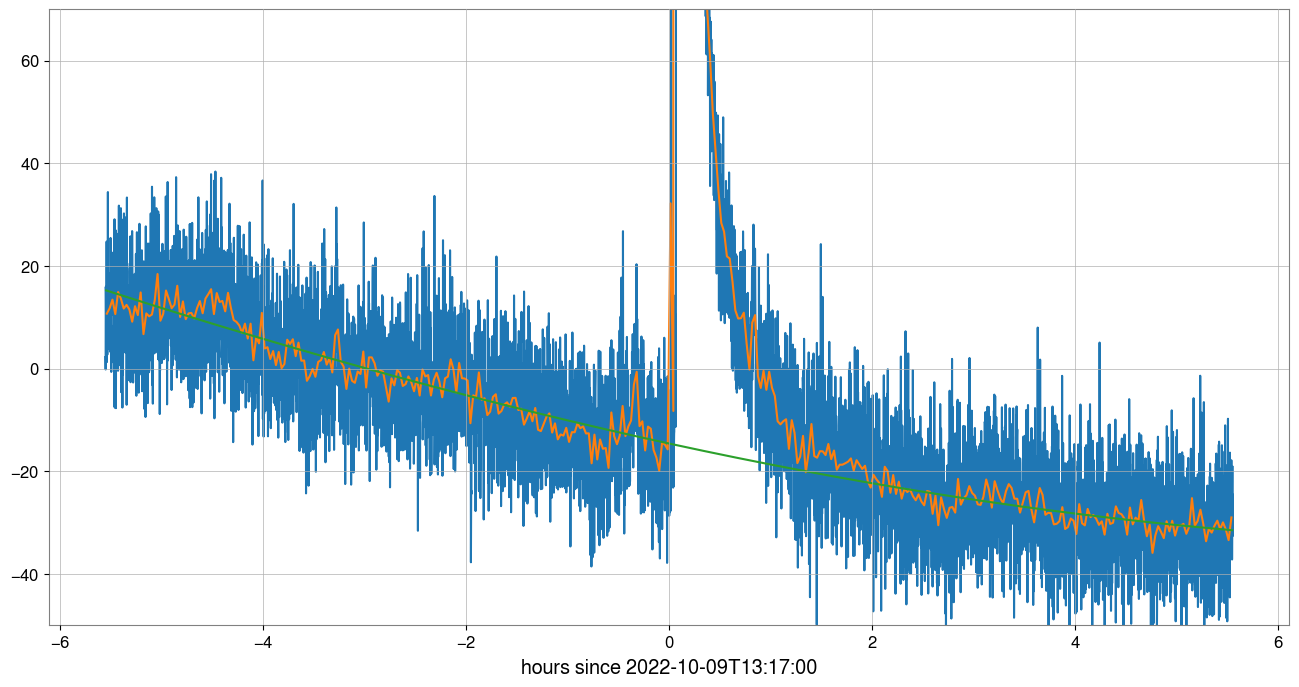

In [ ]:
plt.figure(figsize=(16,8))


for n in 100, 2000:

    plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd)*24,
        rebin(acslc.c, n)/n - bkg
    )

# plt.plot(
#     T[m],
#     (rebin(acslc.c, n)/n - bkg)[m]
# )

plt.plot(
    T,
    F(T, *curve[0])
)

plt.ylim([-50,70])

plt.xlabel(f'hours since {T0_isot}')

In [ ]:
dd

{'T0_isot': '2022-10-09T13:17:00',
 'isgri': {'exposure_s': 63937.34085741686, 'snr': 13.343265533447266},
 'jemx1': {'exposure_s': 86544.6524534557, 'snr': 25.70436668395996},
 'jemx2': {'exposure_s': 84811.5586000002, 'snr': 24.49652671813965},
 'joint_fit': {'e1_keV': 3,
  'e2_keV': 80,
  'flux_ecs': 4.4263e-10,
  'flux_ecs_err_68p': (-2.113000000000001e-11, 2.437000000000004e-11),
  'slope': 2.15041,
  'slope_err_90p': (-0.0712388, 0.0841283)},
 'obs': {'tstart_isot': '', 'tstop_isot': ''},
 'sc': {'barytime': 0.14860478635175947,
  'bodies': {'earth': {'body_dec': -69.422,
    'body_distance': 0,
    'body_in_sc': [96.70700691257376, -177.92729061769077],
    'body_ra': 19.505999999999972,
    'body_size': 2.6519059844215565,
    'integral_parallax': 57.29577951308232,
    'separation': 137648.7},
   'moon': {'body_dec': -69.422,
    'body_distance': 378263.6197848711,
    'body_in_sc': [107.42311113501043, 175.44388878344608],
    'body_ra': 19.505999999999972,
    'body_size': 0

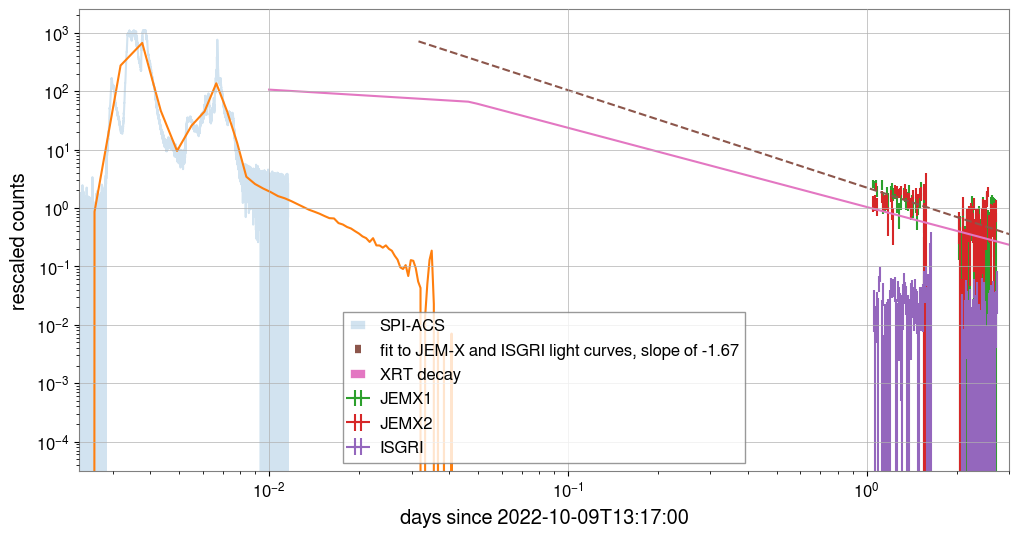

In [ ]:
from statistics import mode


d_j1 = source_products['jemx1_lc'].jemx_lc_0_GRB221009A.data_unit[2].data 
d_j2 = source_products['jemx2_lc'].jemx_lc_0_GRB221009A.data_unit[2].data 
d_i = source_products['isgri_lc'].isgri_lc_2_GRB221009A.data_unit[1].data

plt.figure(figsize=(12,6))

m = acslc.t  - T0_ijd > -200/24/3600
m = acslc.t  - T0_ijd < 1000/24/3600

plt.plot(
    (acslc.t - T0_ijd)[m],
    (acslc.c - bkg)[m]/1e2,
    alpha=0.2,
    label="SPI-ACS"
)

n = 1000
plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd),
        (rebin(acslc.c, n)/n - bkg)/1e2
    )


for d, f, n in [
    (d_j1, 1, 'JEMX1'),
    (d_j2, 1, 'JEMX2'),
    (d_i, 0.01, 'ISGRI'),
]:    
    plt.errorbar(
        d['TIME'] - T0_ijd, 
        f*d['RATE'], f*d['ERROR'], xerr=d['TIMEDEL']/2, ls="", label=n)



plt.loglog()
plt.xlim([200./24/3600, 3])
plt.xlabel(f"days since {T0_isot}")

# plt.axvspan(Time("2022-10-10 13:27:56").mjd - 51544 - T0_ijd, Time("2022-10-10 14:27:28").mjd - 51544 - T0_ijd, alpha=0.2)
# plt.axvspan(Time("2022-10-10 15:02:00").mjd - 51544 - T0_ijd, Time("2022-10-11 04:19:48").mjd - 51544 - T0_ijd, alpha=0.2)

np.sum(d['TIMEDEL'])*24*3600


from scipy.optimize import minimize

# minimize()l
t_model = lambda t, N, slope: N*t**slope

def loss(p):
    N, slope = p
    return np.sum(((t_model(d_j1['TIME'] - T0_ijd, N, slope) - d_j1['RATE']) / d_j1['ERROR'])**2) + \
           np.sum(((t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR'])**2) #+ \
        #    np.sum(((t_model(d_i['TIME'] - T0_ijd, N, slope) - d_i['RATE']) / d_i['ERROR'])**2)

N_fitted, slope_fitted = minimize(loss, [1, 0]).x
t = np.logspace(-1.5, 1, 100)
plt.plot(t, t_model(t, N_fitted, slope_fitted), ls="--", label=f'fit to JEM-X and ISGRI light curves, slope of {slope_fitted:.3g}')

t = np.logspace(-2, 1, 100)
plt.plot(t, xrt_decay(t*24*3600)*1e8, label="XRT decay")

plt.legend()

plt.ylabel("rescaled counts")
plt.savefig("figs/joint_lc.png")

# https://www.swift.ac.uk/burst_analyser/01126853/
# https://gcn.gsfc.nasa.gov/gcn3/32671.gcn3

[]

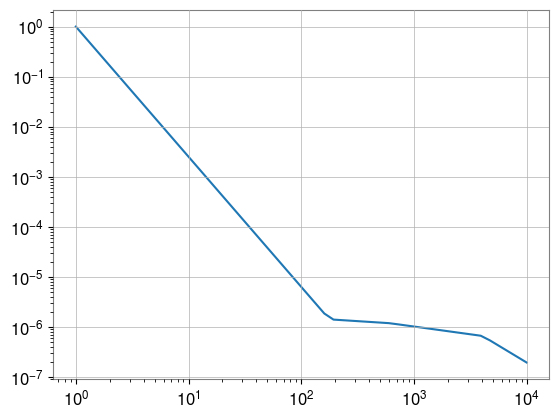

In [ ]:
def xrt_decay(t):
    # #32671
    slopes = """Alpha_1 : 2.6 (+0.4, -0.7)
    Tbreak_1: 177.4 (+2.0, -9.6)
    Alpha_2 : 0.144 (+0.022, -0.026)
    Tbreak_2: 610 (+84, -78)
    Alpha_3 : 0.31 (+0.04, -0.03)
    Tbreak_3: 4060 [+0.23, -0.19])
    Alpha_4 : 1.357 (+/-0.010)"""

    slopes =  {s.split(":")[0].strip(): float(s.split(":")[1].split()[0].strip()) for s in slopes.split("\n")}

    r = t**(-slopes['Alpha_1'])

    m = t > slopes['Tbreak_1']
    rn1 = slopes['Tbreak_1']**(-slopes['Alpha_1']) / slopes['Tbreak_1']**(-slopes['Alpha_2'])
    r[m] = t[m]**(-slopes['Alpha_2']) * rn1

    m = t > slopes['Tbreak_2']
    rn2 = slopes['Tbreak_2']**(-slopes['Alpha_2']) / slopes['Tbreak_2']**(-slopes['Alpha_3']) 
    r[m] = t[m]**(-slopes['Alpha_3']) * rn1 * rn2


    m = t > slopes['Tbreak_3']
    rn3 = slopes['Tbreak_3']**(-slopes['Alpha_3']) / slopes['Tbreak_3']**(-slopes['Alpha_4']) 
    r[m] = t[m]**(-slopes['Alpha_4']) * rn1 * rn2 * rn3
    
    return r


t = np.logspace(0,4)

plt.figure()

plt.plot(
    t,
    xrt_decay(t)
)

plt.loglog()


In [ ]:
with DraftData() as dd:
    dd['T0_isot'] = T0_isot
    dd['obs']['tstart_isot'] = Time(d_j1['TIME'].min()+51544, format='mjd').isot
    dd['obs']['tstart_since_t0'] = d_j1['TIME'].min() - T0_ijd
    dd['obs']['tstop_isot'] = Time(d_j1['TIME'].max()+51544, format='mjd').isot
    dd['obs']['tstop_since_t0'] = d_j1['TIME'].max() - T0_ijd
    dd['obs']['ontime_s'] = np.sum(d_j1['TIMEDEL'])*24*3600

/home/savchenk/miniconda-recent/lib/python3.9/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  self.data = yaml.load(


In [ ]:
with DraftData() as dd:
    dd['scheduled_obs'] = {
        'T1_isot': '2022-10-11 13:52:21',
        'T2_isot': '2022-10-13 00:58:26'
    }

In [ ]:
!curl https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/UTC/2022-10-09T13:17:00/SCWID

255800290010

In [ ]:
with DraftData() as dd:
    dd['sc'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{T0_isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()

In [ ]:
from astropy.io import fits

compton_events = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800290010.000/compton_events.fits.gz")
compton_events1 = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800300021.000////compton_events.fits.gz")
compton_events2 = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800300010.000///compton_events.fits.gz")


In [ ]:
for e in compton_events2:
    print(e.header.get('EXTNAME'))

None
COMP-SGLE-PRW
COMP-MULE-PRW
COMP-MULE-SRW
COMP-SGLE-ALL
COMP-MULE-ALL


In [ ]:
mce = dict()

for i in range(8):
    mce[i] = pd.read_csv(
        io.StringIO(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/genlc/ISGRIRAW_MCE{i}/{T0_ijd}/2000").text), 
        skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)


np.sum([mce[i].c for i in range(8)], axis=0)

array([9415, 9883, 9448, ..., 9744, 9517, 9607])

(0.0, 1000.0)

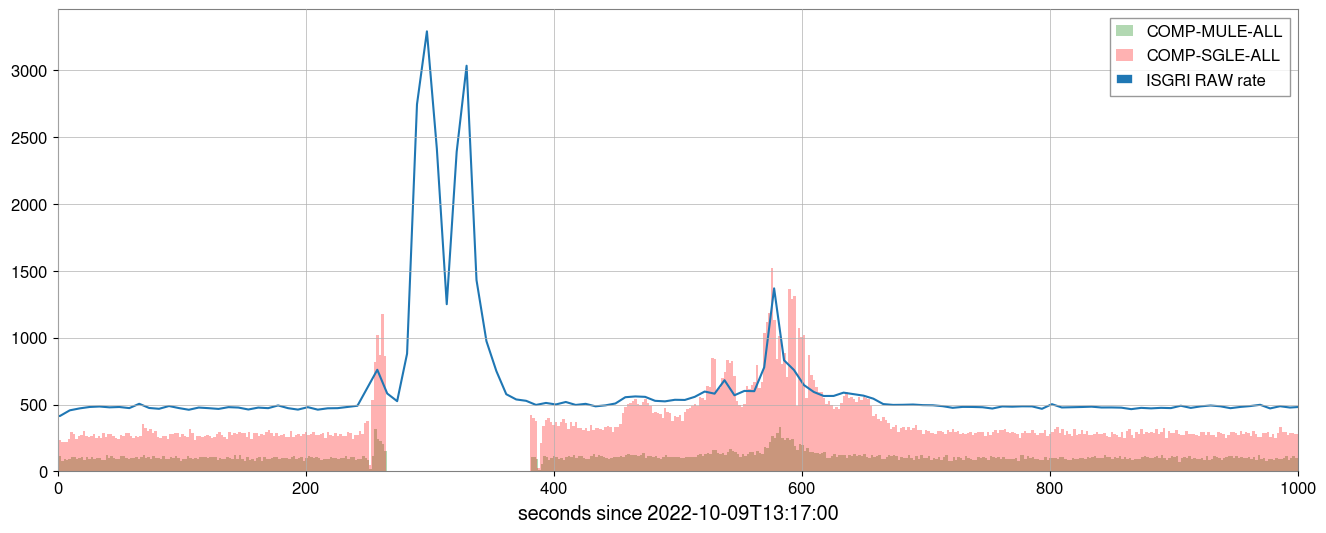

In [ ]:
plt.figure(figsize=(16, 6))

for color, ext in ('g', "COMP-MULE-ALL"), ('r', 'COMP-SGLE-ALL'):
    label=ext
    
    for c in compton_events, compton_events1, compton_events2:
        T = c[ext].data['TIME']
        E = c[ext].data['ISGRI_ENERGY']

        plt.hist((T - T0_ijd)*24*3600, bins=1000, alpha=0.3, color=color, label=label)
        label = None
    
# for i in range(8):
plt.plot((mce[0].t- T0_ijd)*24*3600, np.sum([mce[i].c for i in range(8)], axis=0 )/20, label="ISGRI RAW rate")

plt.legend()
plt.xlabel(f"seconds since {T0_isot}")
plt.xlim([0, 1000])

In [ ]:
mce[0].t[:10], mce[2].t[:10]

(0    8317.530342
 1    8317.530435
 2    8317.530528
 3    8317.530620
 4    8317.530713
 5    8317.530805
 6    8317.530898
 7    8317.530991
 8    8317.531083
 9    8317.531176
 Name: t, dtype: float64,
 0    8317.530342
 1    8317.530435
 2    8317.530528
 3    8317.530620
 4    8317.530713
 5    8317.530805
 6    8317.530898
 7    8317.530991
 8    8317.531083
 9    8317.531176
 Name: t, dtype: float64)